In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter
from metrics import NNSE,ZNRMSE,PPTS,LPTS
from ConvertChineseToPinyin import convert_to_pinyin_capitalized

# Set default font size to 9 and default linewidth to 1
plt.rcParams.update({'font.size': 8, 'lines.linewidth': 1})
hydro_stations = [
    'Tangnaihai', 
    'Guide', 
    'Xunhua']
hydrostation_abbrs = {'Tangnaihai':'TNH','Guide':'GD','Xunhua':'XH'}
hydrostation_channel = {'Tangnaihai':'3','Guide':'14','Xunhua':'9'}
# read observed climate data
hydrostation_metestations = {
    'Tangnaihai': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
    ],
    'Guide': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德',
    ],
    'Xunhua': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德', '同仁',
    ]
}
metestation_controal_area = pd.read_csv('../data/MeteGaugeStationControlArea.csv')
metestation_controal_area_dict = dict(zip(metestation_controal_area['station'], metestation_controal_area['Shape_Area']))

Maduo
MaDuo


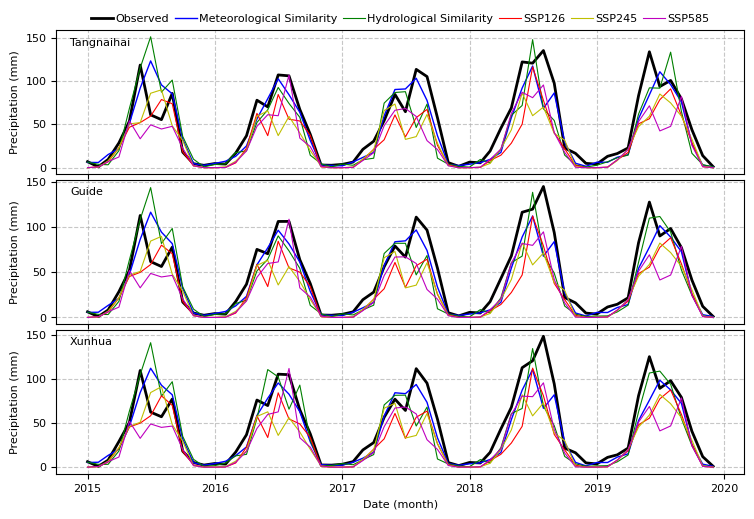

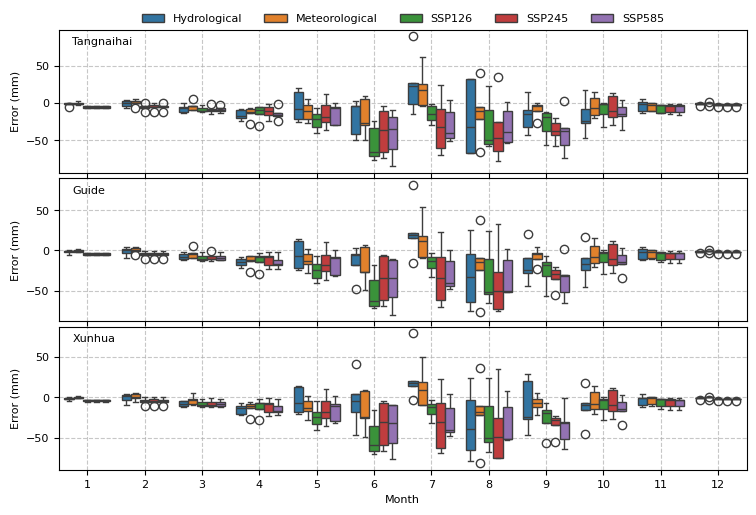

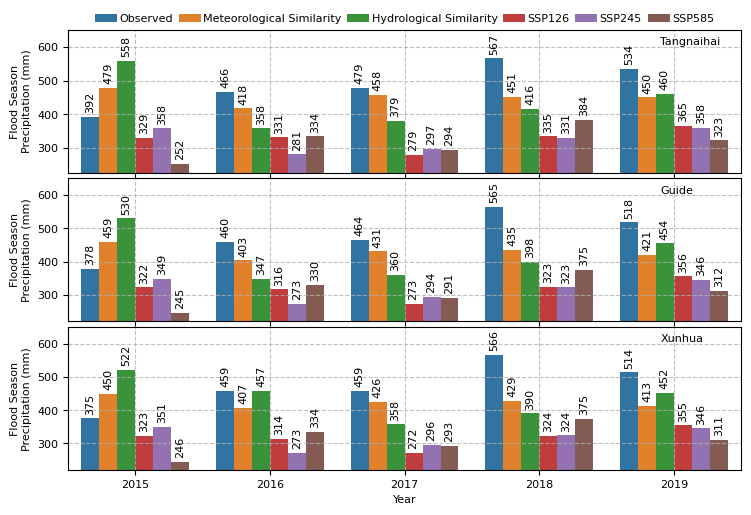

In [27]:
pred_years = np.arange(2015,2020)

# Create first figure for time series plots
fig1 = plt.figure(figsize=(7.48, 5.0))
gs1 = fig1.add_gridspec(3, 1)
obs_pcp_dict = {}
metesim_pcp_dict = {}
hyrosim_pcp_dict = {}
gcm_ssp126_pcp_dict = {}
gcm_ssp245_pcp_dict = {}
gcm_ssp585_pcp_dict = {}
for i, hydro_station in enumerate(hydro_stations):
    station_names = hydrostation_metestations[hydro_station]
    
    total_area = sum(metestation_controal_area_dict[station] for station in station_names)
    weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}
    pred_index = pd.date_range(start=f'{pred_years[0]}-01-01',end=f'{pred_years[-1]}-12-31',freq='MS')
    hyrosim_pcp_df = pd.DataFrame(index=pred_index)
    metesim_pcp_df = pd.DataFrame(index=pred_index)
    obs_pcp_df = pd.DataFrame(index=pred_index)

    #! Get the climate forcing from meteorological similarity years
    mete_similarity_years = pd.read_csv(f'../result/SimilarityYears/SimilarityYears_{hydro_station}.csv', index_col=['tar_year'])
    for station_name in station_names:
        climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                   index_col=['DATE'], parse_dates=['DATE'])

        climate_data_obs = climate_data.copy()

        for pred_year in pred_years:#!Replace the observed data with the meteorological similarity years
            tar_year = pred_year
            ref_year = mete_similarity_years.loc[tar_year-1, station_name] + 1
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
        
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

        climate_data = climate_data.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
        climate_data_obs = climate_data_obs.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
        metesim_pcp_df[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
        obs_pcp_df[station_name] = climate_data_obs['P2020(mm)'].resample('MS').sum() * weights[station_name]
    metesim_pcp_avg = metesim_pcp_df.sum(axis=1)
    obs_pcp_avg = obs_pcp_df.sum(axis=1)
    metesim_pcp_dict[hydro_station] = metesim_pcp_avg
    obs_pcp_dict[hydro_station] = obs_pcp_avg

    #! Get the climate forcing from hydrological similarity years
    hydro_similarity_years = pd.read_csv(f'../result/SimilarityYears/{hydro_station.lower()}_hydrological_similiarity_year.csv')
    similarity_dict = dict(zip(hydro_similarity_years['PredYear'], hydro_similarity_years['SimYear']))
    for station_name in station_names:
        climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                   index_col=['DATE'], parse_dates=['DATE'])
        for pred_year in pred_years:#!Replace the observed data with the hydrological similarity years
            tar_year = pred_year
            ref_year = similarity_dict[pred_year]
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
            
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

        climate_data = climate_data.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
            
        hyrosim_pcp_df[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
    hyrosim_pcp_avg = hyrosim_pcp_df.sum(axis=1)
    hyrosim_pcp_dict[hydro_station] = hyrosim_pcp_avg
    #! Get the climate forcing from GCMs
    gcm_ssp126_pcp_df = pd.DataFrame(index=pred_index)
    gcm_ssp245_pcp_df = pd.DataFrame(index=pred_index)
    gcm_ssp585_pcp_df = pd.DataFrame(index=pred_index)
    for station_name in station_names:
        eng_station_name = convert_to_pinyin_capitalized(station_name)
        gcm_ssp126_data = pd.read_csv(f'../data/UpperYellowRiver_ACCESS-ESM1-5/ssp126/{eng_station_name}.csv',index_col=['date'],parse_dates=['date'])
        gcm_ssp245_data = pd.read_csv(f'../data/UpperYellowRiver_ACCESS-ESM1-5/ssp245/{eng_station_name}.csv',index_col=['date'],parse_dates=['date'])
        gcm_ssp585_data = pd.read_csv(f'../data/UpperYellowRiver_ACCESS-ESM1-5/ssp585/{eng_station_name}.csv',index_col=['date'],parse_dates=['date'])

        gcm_ssp126_data = gcm_ssp126_data.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
        gcm_ssp245_data = gcm_ssp245_data.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
        gcm_ssp585_data = gcm_ssp585_data.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']

        gcm_ssp126_pcp_df[station_name] = gcm_ssp126_data['P(mm)'].resample('MS').sum() * weights[station_name]
        gcm_ssp245_pcp_df[station_name] = gcm_ssp245_data['P(mm)'].resample('MS').sum() * weights[station_name]
        gcm_ssp585_pcp_df[station_name] = gcm_ssp585_data['P(mm)'].resample('MS').sum() * weights[station_name]
    gcm_ssp126_pcp_avg = gcm_ssp126_pcp_df.sum(axis=1)
    gcm_ssp245_pcp_avg = gcm_ssp245_pcp_df.sum(axis=1)
    gcm_ssp585_pcp_avg = gcm_ssp585_pcp_df.sum(axis=1)
    gcm_ssp126_pcp_dict[hydro_station] = gcm_ssp126_pcp_avg
    gcm_ssp245_pcp_dict[hydro_station] = gcm_ssp245_pcp_avg
    gcm_ssp585_pcp_dict[hydro_station] = gcm_ssp585_pcp_avg

    # Plot time series
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(obs_pcp_avg.index, obs_pcp_avg.values, 'k-', label='Observed', linewidth=2)
    ax1.plot(metesim_pcp_avg.index, metesim_pcp_avg.values, 'b-', label='Meteorological Similarity')
    ax1.plot(hyrosim_pcp_avg.index, hyrosim_pcp_avg.values, 'g-', label='Hydrological Similarity', linewidth=0.8)
    ax1.plot(gcm_ssp126_pcp_avg.index, gcm_ssp126_pcp_avg.values, 'r-', label='SSP126', linewidth=0.8)
    ax1.plot(gcm_ssp245_pcp_avg.index, gcm_ssp245_pcp_avg.values, 'y-', label='SSP245', linewidth=0.8)
    ax1.plot(gcm_ssp585_pcp_avg.index, gcm_ssp585_pcp_avg.values, 'm-', label='SSP585', linewidth=0.8)
    ax1.text(0.02, 0.95, hydro_station, transform=ax1.transAxes, fontsize=8, va='top')
    ax1.set_ylabel('Precipitation (mm)', fontsize=8)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    if i == 0:
        ax1.legend(fontsize=8, ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.18), frameon=False, columnspacing=0.5, handletextpad=0.2)
    if i == 2:
        ax1.set_xlabel('Date (month)', fontsize=8)
    else:
        ax1.set_xticklabels([])

plt.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.073, hspace=0.04,wspace=0.05)
plt.savefig(f'../figs/ClimateForcingComparison_TimeSeries_{pred_years[0]}_{pred_years[-1]}.png', dpi=300)
plt.savefig(f'../figs/ClimateForcingComparison_TimeSeries_{pred_years[0]}_{pred_years[-1]}.tif', format='tif', dpi=500)

# Create second figure for boxplots
fig2 = plt.figure(figsize=(7.48, 5.0))
gs2 = fig2.add_gridspec(3, 1)

for i, hydro_station in enumerate(hydro_stations):
    # Get data for current station from dictionaries
    obs_pcp_avg = obs_pcp_dict[hydro_station]
    metesim_pcp_avg = metesim_pcp_dict[hydro_station]
    hyrosim_pcp_avg = hyrosim_pcp_dict[hydro_station]
    gcm_ssp126_pcp_avg = gcm_ssp126_pcp_dict[hydro_station]
    gcm_ssp245_pcp_avg = gcm_ssp245_pcp_dict[hydro_station]
    gcm_ssp585_pcp_avg = gcm_ssp585_pcp_dict[hydro_station]

    # Calculate errors
    hydrosim_pcp_error = hyrosim_pcp_avg - obs_pcp_avg
    metesim_pcp_error = metesim_pcp_avg - obs_pcp_avg
    gcm_ssp126_pcp_error = gcm_ssp126_pcp_avg - obs_pcp_avg
    gcm_ssp245_pcp_error = gcm_ssp245_pcp_avg - obs_pcp_avg
    gcm_ssp585_pcp_error = gcm_ssp585_pcp_avg - obs_pcp_avg

    # Create DataFrame for boxplot
    error_data = []
    months = range(1, 13)
    for month in months:
        # Get errors for each model for this month
        hydrosim_month = hydrosim_pcp_error[hydrosim_pcp_error.index.month == month].values
        metesim_month = metesim_pcp_error[metesim_pcp_error.index.month == month].values
        ssp126_month = gcm_ssp126_pcp_error[gcm_ssp126_pcp_error.index.month == month].values
        ssp245_month = gcm_ssp245_pcp_error[gcm_ssp245_pcp_error.index.month == month].values
        ssp585_month = gcm_ssp585_pcp_error[gcm_ssp585_pcp_error.index.month == month].values
        
        # Add data for each model to DataFrame
        for err in hydrosim_month:
            error_data.append({'Month': month, 'Model': 'Hydrological', 'Error': err})
        for err in metesim_month:
            error_data.append({'Month': month, 'Model': 'Meteorological', 'Error': err})
        for err in ssp126_month:
            error_data.append({'Month': month, 'Model': 'SSP126', 'Error': err})
        for err in ssp245_month:
            error_data.append({'Month': month, 'Model': 'SSP245', 'Error': err})
        for err in ssp585_month:
            error_data.append({'Month': month, 'Model': 'SSP585', 'Error': err})
            
    error_df = pd.DataFrame(error_data)

    # Plot boxplot
    ax2 = fig2.add_subplot(gs2[i])
    sns.boxplot(data=error_df, x='Month', y='Error', hue='Model', ax=ax2)
    ax2.text(0.02, 0.95, hydro_station, transform=ax2.transAxes, fontsize=8, va='top')
    ax2.set_ylabel('Error (mm)', fontsize=8)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    if i == 0:
        ax2.legend(fontsize=8, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.18), frameon=False)
    else:
        ax2.legend().remove()
        
    if i == 2:
        ax2.set_xlabel('Month', fontsize=8)
    else:
        ax2.set_xticklabels([])

plt.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.08, hspace=0.04,wspace=0.05)
plt.savefig(f'../figs/ClimateForcingComparison_Boxplots_{pred_years[0]}_{pred_years[-1]}.png', dpi=300)
plt.savefig(f'../figs/ClimateForcingComparison_Boxplots_{pred_years[0]}_{pred_years[-1]}.tif', format='tif', dpi=500)

# Create third figure for flood season precipitation bar plots
fig3 = plt.figure(figsize=(7.48, 5.0))
gs3 = fig3.add_gridspec(3, 1)

for i, hydro_station in enumerate(hydro_stations):
    # Get data for current station from dictionaries
    obs_pcp_avg = obs_pcp_dict[hydro_station]
    metesim_pcp_avg = metesim_pcp_dict[hydro_station]
    hyrosim_pcp_avg = hyrosim_pcp_dict[hydro_station]
    gcm_ssp126_pcp_avg = gcm_ssp126_pcp_dict[hydro_station]
    gcm_ssp245_pcp_avg = gcm_ssp245_pcp_dict[hydro_station]
    gcm_ssp585_pcp_avg = gcm_ssp585_pcp_dict[hydro_station]

    # Calculate flood season precipitation for each year and model
    flood_season_data = []
    
    for year in pred_years:
        # Get flood season data (May-October) for each model
        flood_mask = (obs_pcp_avg.index.year == year) & (obs_pcp_avg.index.month.isin(range(5,11)))
        
        obs_flood = obs_pcp_avg[flood_mask].sum()
        metesim_flood = metesim_pcp_avg[flood_mask].sum()
        hydrosim_flood = hyrosim_pcp_avg[flood_mask].sum()
        ssp126_flood = gcm_ssp126_pcp_avg[flood_mask].sum()
        ssp245_flood = gcm_ssp245_pcp_avg[flood_mask].sum()
        ssp585_flood = gcm_ssp585_pcp_avg[flood_mask].sum()
        
        flood_season_data.append({
            'Year': year,
            'Observed': obs_flood,
            'Meteorological Similarity': metesim_flood,
            'Hydrological Similarity': hydrosim_flood,
            'SSP126': ssp126_flood,
            'SSP245': ssp245_flood,
            'SSP585': ssp585_flood
        })
    
    flood_df = pd.DataFrame(flood_season_data)
    
    # Melt the dataframe for seaborn plotting
    flood_df_melted = flood_df.melt(id_vars=['Year'], var_name='Model', value_name='Precipitation')
    
    # Get min and max values for y-axis limits
    y_min = flood_df_melted['Precipitation'].min() * 0.9  # Add 10% padding
    y_max = flood_df_melted['Precipitation'].max() * 1.15
    
    # Plot bar plot using seaborn
    ax3 = fig3.add_subplot(gs3[i])
    sns.barplot(data=flood_df_melted, x='Year', y='Precipitation', hue='Model', ax=ax3)
    
    # Set y-axis limits
    ax3.set_ylim(y_min, y_max)
    
    # Add value labels on top of each bar with vertical orientation
    for container in ax3.containers:
        ax3.bar_label(container, fmt='%.0f', padding=3, rotation=90)
    
    ax3.text(0.88, 0.95, hydro_station, transform=ax3.transAxes, fontsize=8, va='top')
    ax3.set_ylabel('Flood Season\nPrecipitation (mm)', fontsize=8)
    ax3.grid(True, linestyle='--', alpha=0.8)
    
    if i == 0:
        ax3.legend(fontsize=8, ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.18), frameon=False, columnspacing=0.5, handletextpad=0.2)
    else:
        ax3.legend().remove()
        
    if i == 2:
        ax3.set_xlabel('Year', fontsize=8)
    else:
        ax3.set_xticklabels([])

plt.subplots_adjust(left=0.09, right=0.99, top=0.96, bottom=0.08, hspace=0.04,wspace=0.05)
plt.savefig(f'../figs/ClimateForcingComparison_FloodSeason_{pred_years[0]}_{pred_years[-1]}.png', dpi=300)
plt.savefig(f'../figs/ClimateForcingComparison_FloodSeason_{pred_years[0]}_{pred_years[-1]}.tif', format='tif', dpi=500)

plt.show()
